In [24]:
import sys
import time
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
REPO = join(os.getenv("REPO"), "ukbb_gwas/bin")
MODEL = join(os.getenv("REPO"), "ukbb_gwas/model")
sys.path.insert(0, REPO)
sys.path.insert(0, MODEL)

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from exomeloader import VariantLoader, EmbeddingLoader, ExomeLoader
from utils import check_ram, check_gpu
from torch_geometric.nn import DataParallel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from sklearn.model_selection import train_test_split

from sgformer import SGFormer
from dataloader import ExomeDataset

In [2]:
model_path = "/orange/sai.zhang/khoa/repos/ukbb_gwas/model/ckpts_alz_g30.9_061625_mane/sgformer_alz_g30.9_mane_80batch_l2_1e-4_lr_1e-3_epoch_189.pth"

In [3]:
test_result_path = "/orange/sai.zhang/khoa/repos/ukbb_gwas/model/test_predictions_g30.9_epoch_189_061625_mane.csv"

In [4]:
cohort_icd = "/orange/sai.zhang/UKBB/pheno/cohort_ICD.csv"
cohort_age = "/orange/sai.zhang/UKBB/pheno/cohort_age.csv"
cohort_sex = "/orange/sai.zhang/UKBB/pheno/cohort_sex.csv"
# read cohort data and merge based on Participant ID
def read_cohort_data():
    icd = pd.read_csv(cohort_icd, index_col=0)
    age = pd.read_csv(cohort_age, index_col=0)
    sex = pd.read_csv(cohort_sex, index_col=0)
    cohort = icd.merge(age, left_index=True, right_index=True)
    cohort = cohort.merge(sex, left_index=True, right_index=True)
    cohort["ID"] = cohort.index
    return cohort
df_cohort = read_cohort_data()

In [5]:
df_cohort

,Diagnoses - ICD10,Diagnoses - ICD9,External causes - ICD10,Underlying (primary) cause of death: ICD10 | Instance 0,Underlying (primary) cause of death: ICD10 | Instance 1,Age at recruitment,Age at death | Instance 0,Age at death | Instance 1,Sex,Genetic sex,ID
Participant ID,,,,,,,,,,,
5734668,D12.5 Sigmoid colon|D50.9 Iron deficiency anae...,NaN,NaN,NaN,NaN,62,NaN,NaN,Female,Female,5734668
1189640,E78.0 Pure hypercholesterolaemia|F17.1 Harmful...,NaN,NaN,NaN,NaN,57,NaN,NaN,Male,NaN,1189640
1633623,E11.9 Without complications|E83.1 Disorders of...,V252 Sterilization,NaN,NaN,NaN,56,NaN,NaN,Male,Male,1633623
5616756,"D86.0 Sarcoidosis of lung|J45.9 Asthma, unspec...",NaN,NaN,NaN,NaN,49,NaN,NaN,Female,Female,5616756
3648157,K21.0 Gastro-oesophageal reflux disease with o...,NaN,NaN,NaN,NaN,59,NaN,NaN,Female,Female,3648157
...,...,...,...,...,...,...,...,...,...,...,...
2702378,"K02.9 Dental caries, unspecified|K46.9 Unspeci...",NaN,W18.0 Home,NaN,NaN,62,NaN,NaN,Female,Female,2702378
2361128,K01.1 Impacted teeth,NaN,NaN,NaN,NaN,41,NaN,NaN,Female,NaN,2361128
2214355,C50.4 Upper-outer quadrant of breast,NaN,NaN,NaN,NaN,48,NaN,NaN,Female,Female,2214355


In [22]:
class Config:
    DEBUG = "1"
    BATCH_SIZE = 32
    NUM_WORKERS = 8
    IN_CHANNELS = 1152
    HIDDEN_DIMS = 64
    OUT_CHANNELS = 2
    LEARNING_RATE = 1e-4
    L2_LAMBDA = 0.001
    EPOCHS = 250

def create_model(device):
    """Create and initialize the model"""
    model = SGFormer(
        in_channels=Config.IN_CHANNELS,
        hidden_channels=Config.HIDDEN_DIMS,
        out_channels=Config.OUT_CHANNELS,
        trans_num_layers=2,
        trans_num_heads=1,
        trans_dropout=0.5,
        gnn_num_layers=3,
        gnn_dropout=0.5,
        graph_weight=0.5,
        aggregate='add'
    ).to(device)
    
    
    return model



In [7]:
df_test_result = pd.read_csv(test_result_path)

In [8]:
df_test_result = df_test_result.merge(df_cohort, left_on="sample_id", right_on="ID", how="left")

Text(0.5, 0, 'Predicted Probability')

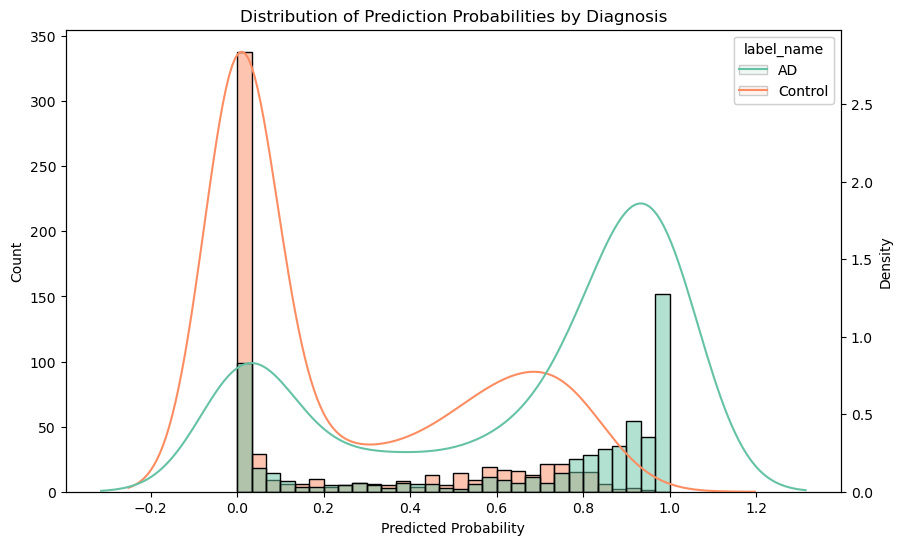

In [12]:
# Plot histogram with KDE overlay
fig, ax1 = plt.subplots(figsize=(10,6))

# Map labels to meaningful names
# Create a copy of true_label column to preserve original values
df_test_result['label_name'] = df_test_result['true_label'].map({0: 'Control', 1: 'AD'})

# Plot histogram on primary y-axis
sns.histplot(data=df_test_result, x="prob_positive", hue="label_name", multiple="layer", bins=30, stat="count", ax=ax1, palette="Set2")
ax1.set_ylabel("Count")

# Create secondary y-axis for KDE
ax2 = ax1.twinx()
sns.kdeplot(data=df_test_result, x="prob_positive", hue="label_name", common_norm=False, ax=ax2, palette="Set2")
ax2.set_ylabel("Density")

plt.title("Distribution of Prediction Probabilities by Diagnosis")
ax1.set_xlabel("Predicted Probability")


/tmp/ipykernel_831265/2870276840.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test_result, x="label_name", y="Age at recruitment", palette="Set2")


<Axes: title={'center': 'Age Distribution by Diagnosis Group'}, xlabel='Diagnosis', ylabel='Age at Recruitment'>

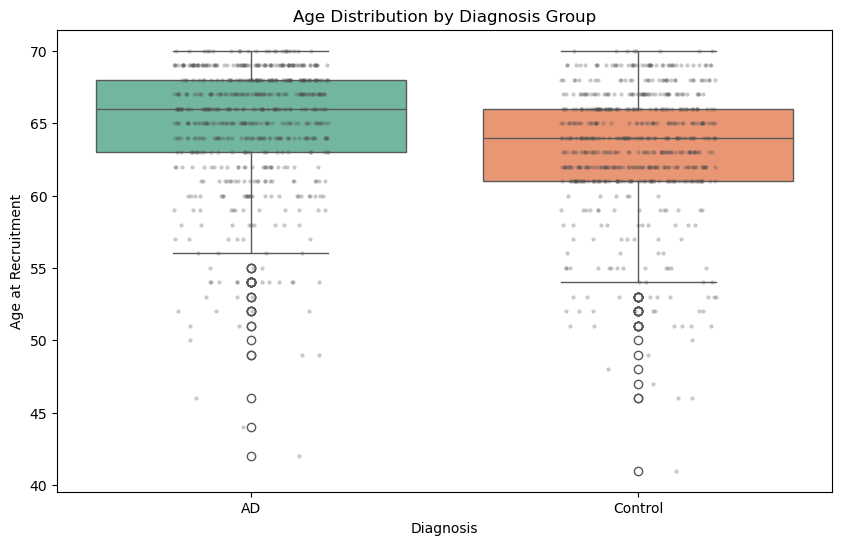

In [13]:
# Plot age distribution for control vs AD groups
plt.figure(figsize=(10,6))

sns.boxplot(data=df_test_result, x="label_name", y="Age at recruitment", palette="Set2")
plt.title("Age Distribution by Diagnosis Group")
plt.xlabel("Diagnosis")
plt.ylabel("Age at Recruitment")

# Add individual points with jitter
sns.stripplot(data=df_test_result, x="label_name", y="Age at recruitment", 
              color='0.3', size=3, alpha=0.3, jitter=0.2)


Text(0, 0.5, 'Count')

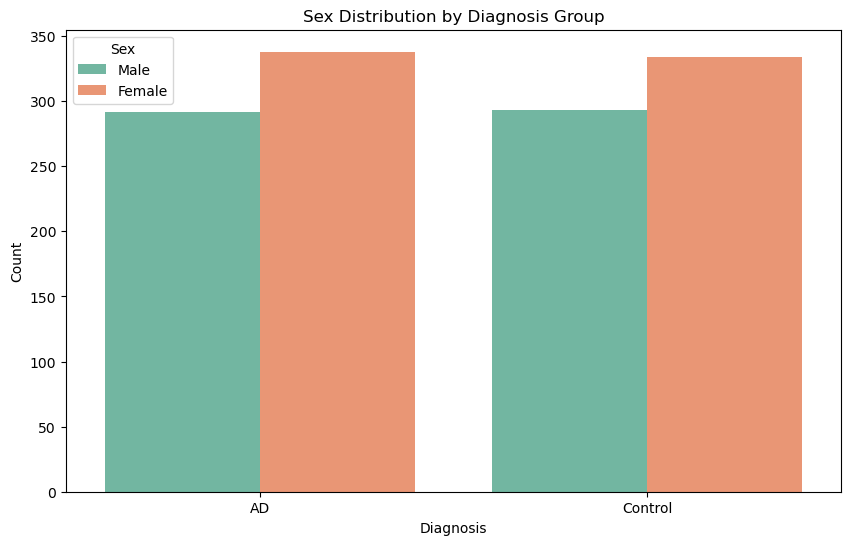

In [14]:
# plot Sex distribution for control vs AD groups
plt.figure(figsize=(10,6))
sns.countplot(data=df_test_result, x="label_name", hue="Sex", palette="Set2")
plt.title("Sex Distribution by Diagnosis Group")
plt.xlabel("Diagnosis")
plt.ylabel("Count")


Text(0, 0.5, 'Diagnosis')

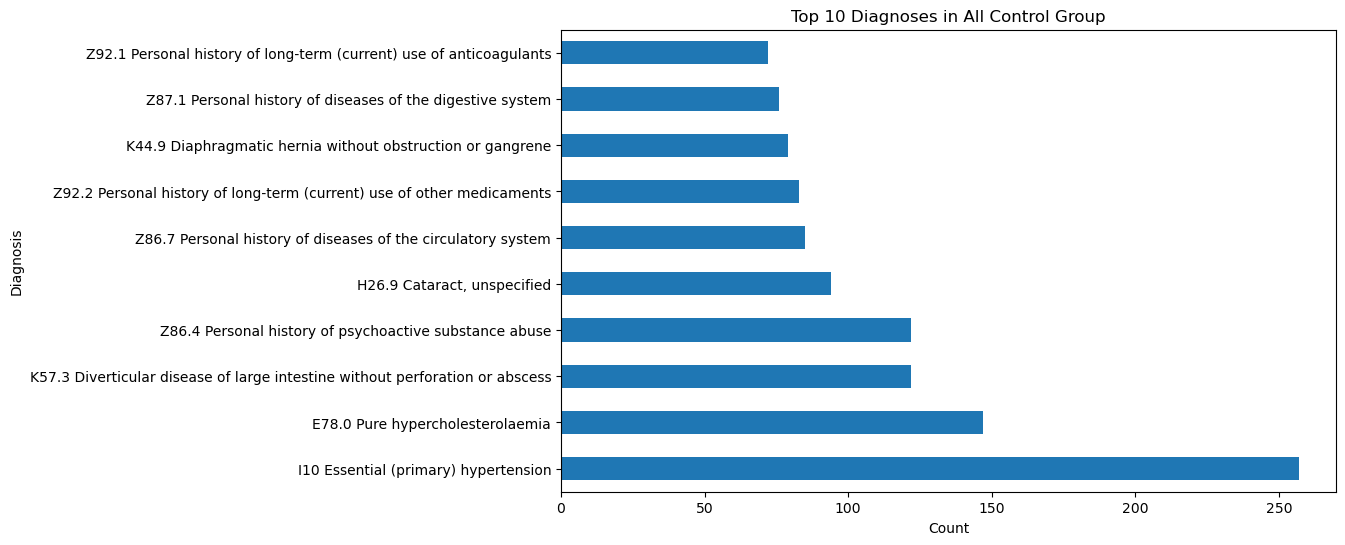

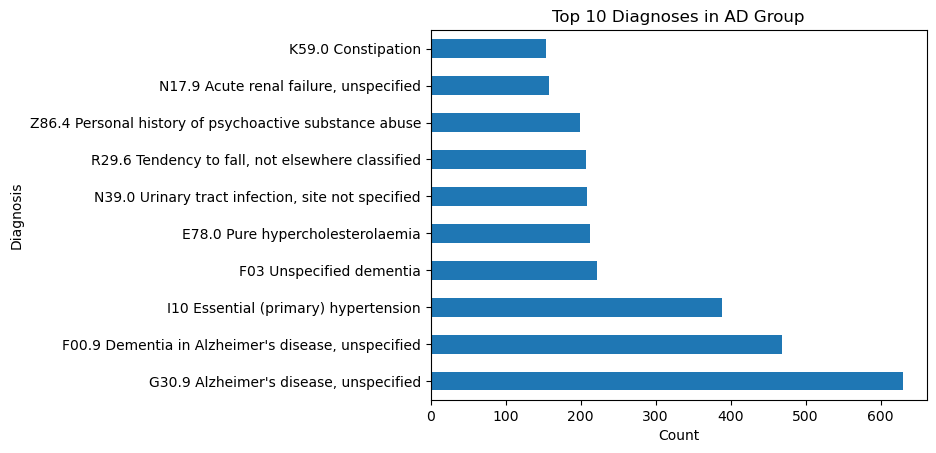

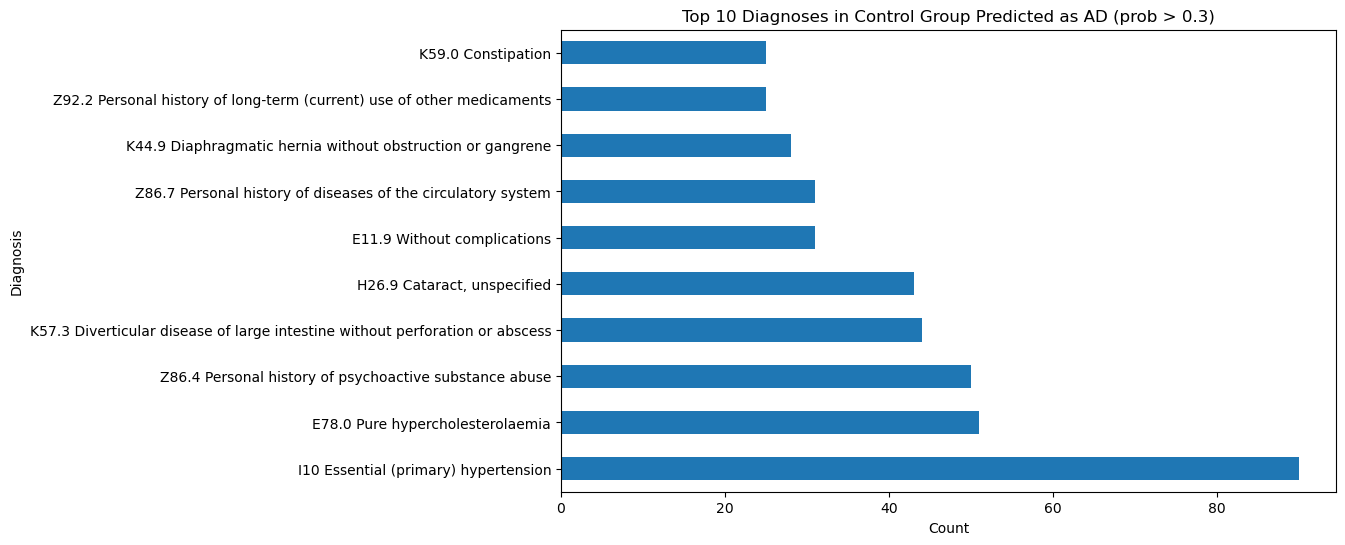

In [15]:
# Get diagnoses for all control patients
control_diagnoses = df_test_result[df_test_result["label_name"] == "Control"]["Diagnoses - ICD10"].str.split("|").explode().value_counts()

# Plot top 10 diagnoses for all controls
plt.figure(figsize=(10,6))
control_diagnoses.head(10).plot(kind="barh")
plt.title("Top 10 Diagnoses in All Control Group")
plt.xlabel("Count")
plt.ylabel("Diagnosis")
# barplot top 10 horizontally
plt.figure() # Create new figure for AD plot
df_test_result[df_test_result["label_name"] == "AD"]["Diagnoses - ICD10"].str.split("|").explode().value_counts().head(10).plot(kind="barh")
plt.title("Top 10 Diagnoses in AD Group")
plt.xlabel("Count") 
plt.ylabel("Diagnosis")
# Get diagnoses for controls predicted as AD (prob > 0.5)
control_false_pos = df_test_result[(df_test_result["label_name"] == "Control") & 
                                  (df_test_result["prob_positive"] > 0.3)]["Diagnoses - ICD10"].str.split("|").explode().value_counts()

# Plot top 10 diagnoses for controls predicted as AD
plt.figure(figsize=(10,6))
control_false_pos.head(10).plot(kind="barh")
plt.title("Top 10 Diagnoses in Control Group Predicted as AD (prob > 0.3)")
plt.xlabel("Count")
plt.ylabel("Diagnosis")



/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 0, 'Correlation')

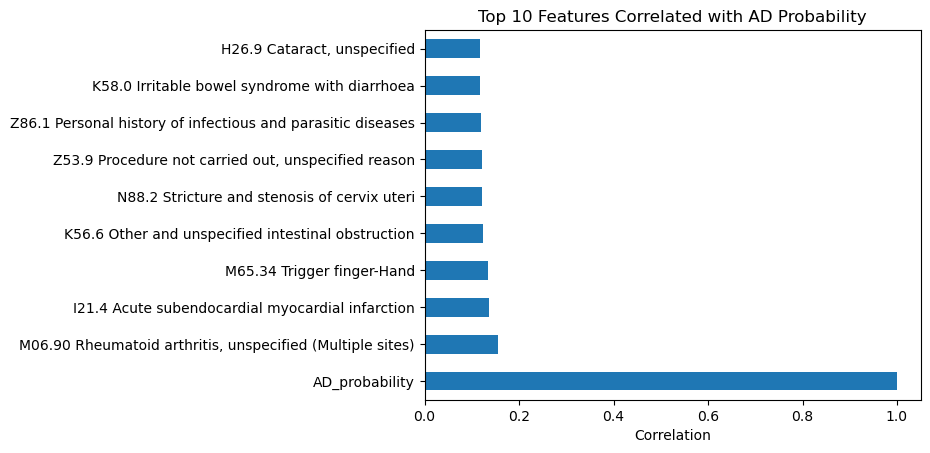

In [16]:
# Get all control patients' diagnoses
control_diagnoses = df_test_result[df_test_result["label_name"] == "Control"]["Diagnoses - ICD10"]

# Split the ICD10 codes and create a binary matrix 
icd10_matrix = pd.get_dummies(control_diagnoses.str.split('|').explode())

# Group back by patient ID to get one row per patient
icd10_matrix = icd10_matrix.groupby(level=0).sum()

# Convert to binary (0/1) rather than counts
icd10_matrix = (icd10_matrix > 0).astype(int)

# Add AD label and prediction probability columns
control_patients = df_test_result[df_test_result["label_name"] == "Control"]
icd10_matrix["AD_label"] = control_patients["true_label"]
icd10_matrix["AD_probability"] = control_patients["prob_positive"]

# calculate mutual information between AD_probability and each feature
from sklearn.metrics import mutual_info_score
mutual_info_score(icd10_matrix["AD_label"], icd10_matrix["AD_probability"])
# plot the top 10 features
icd10_matrix.corrwith(icd10_matrix["AD_probability"]).sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top 10 Features Correlated with AD Probability")
plt.xlabel("Correlation")

In [17]:
df_test_result[(df_test_result["label_name"] == "Control") & (df_test_result["prob_positive"] > 0.92)]["Diagnoses - ICD10"].values

array(['F17.1 Harmful use|J38.7 Other diseases of larynx|M85.86 Other specified disorders of bone density and structure (Lower leg)|S82.21 Fracture of shaft of tibia (open)|V23.4 Driver injured in traffic accident|Z47.8 Other specified orthopaedic follow-up care|Z50.1 Other physical therapy|Z53.8 Procedure not carried out for other reasons'],
      dtype=object)

/tmp/ipykernel_831265/3758836597.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_test_result[(df_test_result["label_name"] == "Control") & (df_test_result["prob_positive"] > 0.8)],


Text(0, 0.5, 'Age at Recruitment')

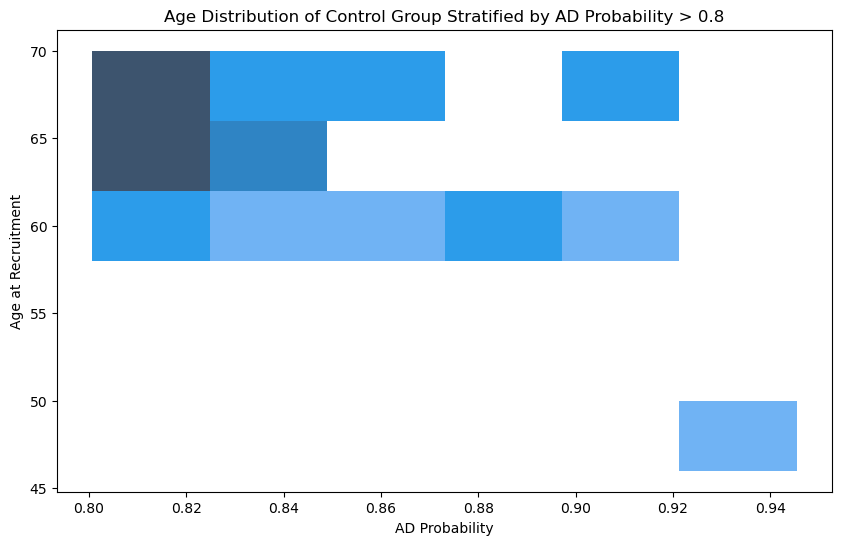

In [18]:
# plot age distribution of AD group stratified by AD probability < 0.5 or > 0.5
plt.figure(figsize=(10,6))
sns.histplot(data=df_test_result[(df_test_result["label_name"] == "Control") & (df_test_result["prob_positive"] > 0.8)],
     x="prob_positive", y="Age at recruitment", palette="Set2")
plt.title("Age Distribution of Control Group Stratified by AD Probability > 0.8") 
plt.xlabel("AD Probability")
plt.ylabel("Age at Recruitment")


In [25]:
multilabel_matrix_path = "/orange/sai.zhang/UKBB/finngen/label_matrix.npy"
sample_path = "/orange/sai.zhang/UKBB/finngen/sample_uid.txt"
variant_db = join(os.getenv("PROCESSED_DATA"), "processed/sqlite/ukbb_sample_indexed_merged2.db")
embedding_db = join(os.getenv("PROCESSED_DATA"), "processed/embeddings/protein_embeddings.h5")
splits_np = np.load(join(os.getenv("PROCESSED_DATA"),"splits", "splits.npz"))
refseq_path = "/orange/sai.zhang/khoa/data/RefSeqGene/GRCh38_latest_rna.gbff.tsv"
network_path = "/orange/sai.zhang/khoa/data/biokg.csv"
REF_DB = join(os.getenv("PROCESSED_DATA_EUR"), "processed/ref_exome_auto_mane.csv")
normalization_matrix = np.load(join(os.getenv("PROCESSED_DATA"), "processed", "normalization_auto_mane.npz"))

eur_samples = VariantLoader(variant_db, "merged_variants").get_all_samples()
multilabel_matrix = np.load(multilabel_matrix_path)
sample_ids = pd.read_csv(sample_path, header = None).to_numpy().flatten()
id2index = {sample_id: index for index, sample_id in enumerate(sample_ids)}
eur_indices = [id2index[sample_id] for sample_id in eur_samples if sample_id in id2index]
eur_multilabel_matrix = multilabel_matrix[eur_indices]
eur_id2index = {sample_id: index for index, sample_id in enumerate(eur_samples)}
eur_index2id = {index : sample_id  for index, sample_id in enumerate(eur_samples)}

df_refgenome = pd.read_csv(REF_DB)
df_refseq = pd.read_csv(refseq_path, sep = "\t")
df_network = pd.read_csv(network_path)
df_refseq["transcript"] = df_refseq.Accession.str.split(".").str[0]
df_refgenome["Gene"] = df_refgenome.transcript.map(df_refseq.set_index("transcript")["Gene"])
df_htemp = df_network[["h_type", "h_id"]]
df_ttemp = df_network[["t_type", "t_id"]]
network_genes = set(df_ttemp[df_ttemp["t_type"] == "Gene"]["t_id"].unique()).\
                union(set(df_htemp[df_htemp["h_type"] == "Gene"]["h_id"].unique()))
df_group = df_refgenome.reset_index().groupby("Gene").agg(list).sort_values("index")
df_group["new_index"] = np.arange(len(df_group))
gene_groups = df_group["index"].tolist()
df_network = df_network[(df_network.rel.str.startswith("Gene")) & (df_network.rel.str.endswith("Gene"))]
df_network["h_exome_id"] = df_network["h_id"].map(df_group["new_index"])
df_network["t_exome_id"] = df_network["t_id"].map(df_group["new_index"])
df_network = df_network.dropna()
df_network = df_network.assign(
    h_exome_id = lambda df: df.h_exome_id.astype(int),
    t_exome_id = lambda df: df.t_exome_id.astype(int),
)
edges = torch.tensor(df_network[["h_exome_id", "t_exome_id"]].values).T

variant_loader   = VariantLoader(variant_db, "merged_variants")
embedding_loader = EmbeddingLoader(embedding_db, metric="mean")
exome_loader     = ExomeLoader(variant_loader, embedding_loader, REF_DB)

Loading embeddings: 100%|██████████| 24/24 [00:40<00:00,  1.70s/it]


In [34]:
alz_train_test = np.load(join(os.getenv("PROCESSED_DATA"), "alz_g30.9_train_test_split.npz"))
train_index = alz_train_test["train_index"]
val_index = alz_train_test["val_index"]
test_index = alz_train_test["test_index"]
y_train = alz_train_test["train_label"]
y_val = alz_train_test["val_label"]
y_test = alz_train_test["test_label"]
train_index = [eur_id2index[i] for i in train_index]
val_index = [eur_id2index[i] for i in val_index]
test_index = [eur_id2index[i] for i in test_index]

train_dataset = ExomeDataset(train_index, eur_index2id, exome_loader, eur_multilabel_matrix, \
                             normalization_matrix, gene_groups, binary=True, binary_labels=y_train)
val_dataset   = ExomeDataset(val_index, eur_index2id,  exome_loader, eur_multilabel_matrix,\
                             normalization_matrix, gene_groups, binary=True, binary_labels=y_val)
test_dataset  = ExomeDataset(test_index, eur_index2id, exome_loader, eur_multilabel_matrix,\
                             normalization_matrix, gene_groups, binary=True, binary_labels=y_test)

# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=8)
# val_dataloader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=8)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=0)

def toGraphBatch(
    X: torch.Tensor,           # (B, N, D)
    edge_index: torch.Tensor   # (2, E)
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Given a batch of node features X and a single shared edge_index,
    produces:
      - x_batch:       (B*N, D)
      - edge_index_batch: (2, B*E)
      - batch_vector:  (B*N,) mapping each node to [0..B-1]
    for use in PyG.
    """
    B, N, D = X.shape
    E = edge_index.size(1)

    # 1) flatten features
    x_batch = X.reshape(B * N, D)

    # 2) construct batch vector: [0..B-1] each repeated N times
    batch_vector = torch.arange(B, device=X.device).repeat_interleave(N)

    # 3) repeat & shift edge_index for each graph
    ei_rep = edge_index.repeat(1, B)  # (2, B*E)
    offsets = torch.arange(B, device=X.device).repeat_interleave(E).mul(N)
    offsets = offsets.unsqueeze(0).repeat(2, 1)  # (2, B*E)
    edge_index_batch = ei_rep + offsets

    return x_batch, edge_index_batch, batch_vector

In [29]:
from captum.attr import IntegratedGradients

In [166]:
# Inference with Integrated Gradients
ig = IntegratedGradients(model)
all_probs = []
all_preds = []
y_true = []
attributions = []

for x, y in test_dataloader:
    print(y)
    x_batch, edge, batch = toGraphBatch(x, edges)
    x_batch = x_batch.float().to(device)
    edge = edge.to(device) 
    batch = batch.to(device)
    
    # Get model prediction
    logits = model(x_batch, edge, batch)
    probs = torch.softmax(logits, dim=1)[:, 1]
    print(probs)
    # Calculate attributions
    baseline = torch.zeros_like(x_batch)
    attr = ig.attribute(x_batch, 
                       additional_forward_args=(edge, batch),
                       target=1,
                       n_steps=50,
                       internal_batch_size=1,
                       baselines=baseline)
    
    all_probs.append(probs.detach().cpu().numpy())
    y_true.append(y.numpy())
    attributions.append(attr.detach().cpu().numpy())
    # break after 5
    if len(attributions) >= 5:
        break

all_probs = np.stack(all_probs, axis=0)
all_preds = (all_probs >= 0.5).astype(int)
y_true = np.concatenate(y_true)
attributions = np.concatenate(attributions)

# save the attributions
np.save("attributions.npy", attributions)


tensor([1])
tensor([0.9524], device='cuda:0', grad_fn=<SelectBackward0>)


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17871 equal to the number of examples.
  warnings.warn(


tensor([0])
tensor([0.7129], device='cuda:0', grad_fn=<SelectBackward0>)


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17871 equal to the number of examples.
  warnings.warn(


tensor([1])
tensor([0.2869], device='cuda:0', grad_fn=<SelectBackward0>)


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17871 equal to the number of examples.
  warnings.warn(


tensor([1])
tensor([1.0000], device='cuda:0', grad_fn=<SelectBackward0>)


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17871 equal to the number of examples.
  warnings.warn(


tensor([1])
tensor([0.8416], device='cuda:0', grad_fn=<SelectBackward0>)


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/captum/attr/_utils/batching.py:45: UserWarning: Internal batch size cannot be less than the number of input examples. Defaulting to internal batch size of 17871 equal to the number of examples.
  warnings.warn(


In [165]:
attr.shape

torch.Size([17871, 1152])

In [151]:
attributions.reshape(5, -1, 1152)[1]

array([[-3.70164182e-06,  6.99816541e-07, -1.08324971e-06, ...,
        -1.23017890e-06, -1.61288693e-06,  2.46267604e-06],
       [ 9.36952385e-06, -1.07680293e-05,  1.70455917e-05, ...,
        -3.37598450e-06,  2.40030625e-06, -1.33103379e-05],
       [-1.11663408e-07, -1.27843204e-06, -2.75680829e-06, ...,
        -7.76139974e-07,  2.41926467e-07,  9.11791149e-06],
       ...,
       [-2.18232074e-07, -3.01885407e-07,  6.23777934e-08, ...,
         8.85784337e-08, -4.28270445e-07,  1.82867006e-07],
       [-3.56442069e-08, -7.58132066e-08, -1.18662504e-08, ...,
         4.30379828e-09, -9.97204768e-08,  5.06946503e-09],
       [ 1.35502249e-06, -3.41523327e-06,  5.69586424e-08, ...,
        -1.08995047e-06, -1.50722168e-07, -1.37442090e-07]])

In [160]:
attributions.shape

(89355, 1152)

In [115]:
# read the attributions
attributions = np.load("attributions.npy")



In [127]:
model

SGFormer(
  (trans_conv): SGModule(
    (attns): ModuleList(
      (0-1): 2 x SGFormerAttention(heads=1, head_channels=64)
    )
    (fcs): ModuleList(
      (0): Linear(in_features=1152, out_features=64, bias=True)
    )
    (bns): ModuleList(
      (0-2): 3 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (graph_conv): GraphModule(
    (convs): ModuleList(
      (0-2): 3 x GCNConv(64, 64)
    )
    (fcs): ModuleList(
      (0): Linear(in_features=1152, out_features=64, bias=True)
    )
    (bns): ModuleList(
      (0-3): 4 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gate_nn): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (att_pool): AttentionalAggregation(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )

(17871,)

In [107]:
np.argsort(abs(attributions.reshape(5, -1, 1152)).sum(axis=0).sum(axis=1))[-10:][::-1]

array([11240, 14414,  7843, 16441, 15875, 10956,  9615,  2880, 12404,
       14710])

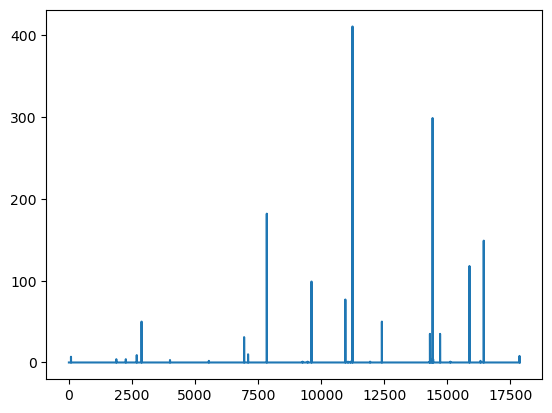

In [137]:
plt.plot((attributions.reshape(5, -1, 1152) > 0.01).sum(axis=0).sum(axis=1))

In [133]:
abs(attributions.reshape(5, -1, 1152) > 0.001).max(axis=-1).shape

(5, 17871)

In [143]:
# Get indices of top 10 features by summing absolute attributions across patients and features
top_10_indices = np.argsort(((attributions.reshape(5, -1, 1152))).sum(axis=-1).sum(axis=0))[-10:][::-1]

# Show the genomic information for top 10 features
df_refgenome.iloc[top_10_indices]

,chr,transcript,ID,Gene
11240,chr12,NM_016123,ref_20252,IRAK4
9615,chr11,NM_024079,ref_17496,ALG8
15875,chr19,NM_001129994,ref_28379,KCTD15
15443,chr19,NM_000041,ref_27693,APOE
7859,chr8,NM_001354870,ref_14131,MYC
7843,chr8,NM_001100878,ref_14100,MROH6
8517,chr9,NM_024761,ref_15341,MOB3B
2689,chr2,NM_006196,ref_4831,PCBP1
4427,chr4,NM_001375477,ref_8021,HERC3
16886,chr20,NM_005225,ref_30053,E2F1


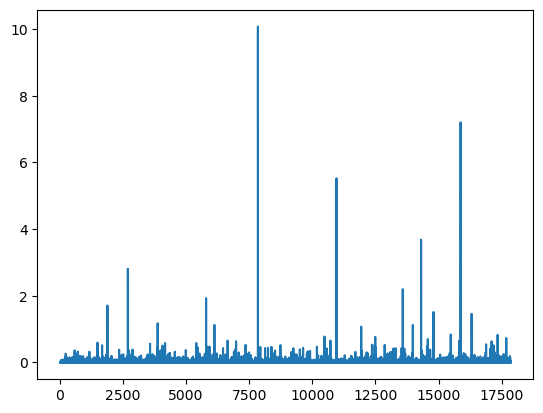

In [65]:
plt.plot(abs(attributions).sum(axis=1))


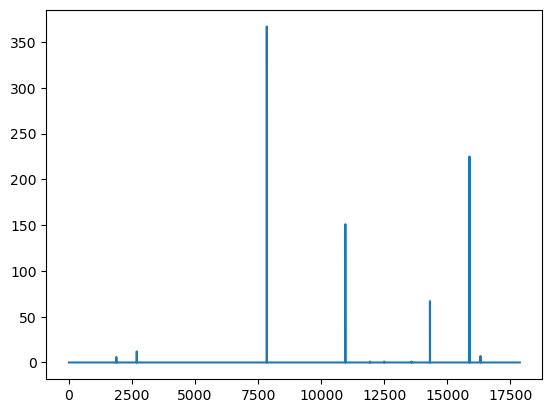

In [64]:
plt.plot((abs(attributions) > 0.01).sum(axis=1))


KeyboardInterrupt: 

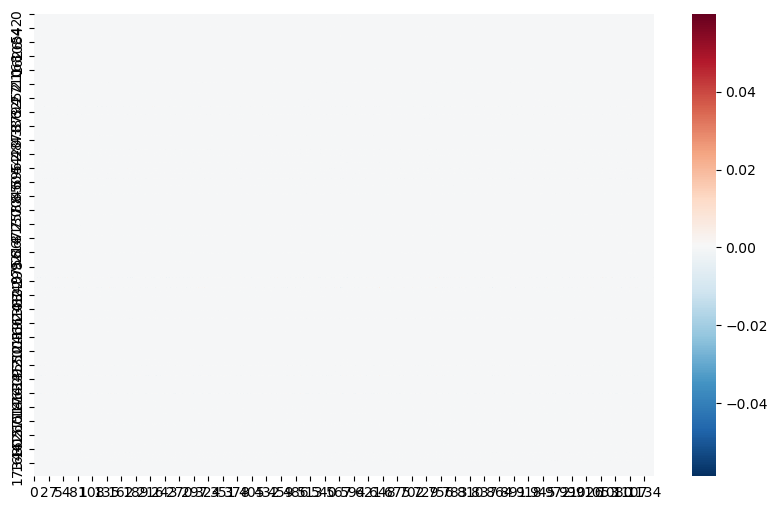

In [49]:
# plot the attributions
plt.figure(figsize=(10,6))
sns.heatmap(attributions, cmap="RdBu_r")
plt.title("Attributions")
plt.xlabel("Feature")
plt.ylabel("Patient")
plt.show()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# get the top 10 features



/tmp/ipykernel_831265/1504081285.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


SGFormer(
  (trans_conv): SGModule(
    (attns): ModuleList(
      (0-1): 2 x SGFormerAttention(heads=1, head_channels=64)
    )
    (fcs): ModuleList(
      (0): Linear(in_features=1152, out_features=64, bias=True)
    )
    (bns): ModuleList(
      (0-2): 3 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (graph_conv): GraphModule(
    (convs): ModuleList(
      (0-2): 3 x GCNConv(64, 64)
    )
    (fcs): ModuleList(
      (0): Linear(in_features=1152, out_features=64, bias=True)
    )
    (bns): ModuleList(
      (0-3): 4 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gate_nn): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (att_pool): AttentionalAggregation(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )